# **BLU365 - Teste técnico** ![1](img/índice.png)

## **Implementação em Pandas**

Este *notebook* é referente à solução do teste proposto pela equipe técnica da BLU365. O teste consiste em analisar uma [base de dados](teste.csv), buscando averiguar quais acordos registrados estão ou não estão válidos. Os critérios básicos para considerar um acordo como válido são:
- O valor total do acordo deve ser igual à soma de todas as parcelas
- O vencimento da primeira parcela deve cair em um dia útil

Este *notebook* possui a versão da análise feita em `pandas`. Além deste pacote, ainda é usado o pacote `wokalendar`, que analisa quais *timestamps* são referentes aos dias de trabalho.

Caso deseje saber mais informações, sinta-se livre [para me contatar](https://github.com/igor-yamamoto).


🐉 *Code on!* 🐉

## Importação de bibliotecas e dos dados

In [1]:
import pandas as pd

In [2]:
dados = pd.read_csv("teste.csv", sep='|', dtype={'documento':str})
dados.head()

,documento,nome,contrato,ValorContrato,ContratoPlano,ValorParcela,DataVencimento
0,76748291623,Bryan Barros,CX-287157746696447087647084574665383433006,38610,10,3861,2018-05-21
1,21056684887,Maria Julia da Rosa,CX-61718558756223880664003750480258706095,9464,4,2366,2018-05-08
2,31133201431,Anthony Melo,CX-163731311009942175702867182050398914445,14285,5,2857,2018-05-05
3,94110246446680,Dr. Augusto Silveira,CX-182496437548146647700452378699383440824,37158,22,1689,2018-04-05
4,64431473462766,Maysa Lopes,CX-81229770554257118009833799243087140596,21284,17,1252,2018-03-06


Convertendo o campo de data para o tipo datetime:

In [3]:
dados['DataVencimento'] = pd.to_datetime(dados['DataVencimento'], format = "%Y-%m-%d")

In [4]:
dados.dtypes

documento                 object
nome                      object
contrato                  object
ValorContrato              int64
ContratoPlano              int64
ValorParcela               int64
DataVencimento    datetime64[ns]
dtype: object

## Verificando os valores dos acordos

Os valores dos acordos (valor negociado para quitar as dívidas) devem ser iguais ao valor da soma de todas as parcelas do acordo. Assim, é possível procurar pelos valores de acordo que **não são iguais à quantidade de parcelas vezes o valor de cada parcela**:

In [5]:
dados[dados['ValorContrato'] != dados['ValorParcela']*dados['ContratoPlano']].shape[0]

0

Logo, todos os valores dos acordos são iguais ao valor de cada parcela vezes a quantidade de parcelas a serem pagas. Portanto, **nenhum acordo é invalidado** por esta condição.

## Verificando quais contratos vencem em dias úteis

Para verificar quais contratos vencem em dias úteis, será utilizado o pacote `workalendar`. Assim:

In [6]:
from workalendar.america import Brazil

cal = Brazil()

É possível averiguar quais são os feriados registrados no pacote. Para tal, é possível identificar que o intervalo de tempo que diz respeito aos dados no arquivo csv é referente ao ano de $2018$:

In [7]:
(dados['DataVencimento'].min(), dados['DataVencimento'].max())

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-25 00:00:00'))

In [8]:
cal.holidays(2018)

[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 4, 1), 'Easter Sunday'),
 (datetime.date(2018, 4, 21), "Tiradentes' Day"),
 (datetime.date(2018, 5, 1), 'Labour Day'),
 (datetime.date(2018, 9, 7), 'Independence Day'),
 (datetime.date(2018, 10, 12), 'Our Lady of Aparecida'),
 (datetime.date(2018, 11, 2), "All Souls' Day"),
 (datetime.date(2018, 11, 15), 'Republic Day'),
 (datetime.date(2018, 12, 25), 'Christmas Day')]

Além dos feriados registrados acima referente ao ano de 2018, ainda se faz necessário considerar [os feriados nacionais registrados no calendário bancário](https://feriadosbancarios.febraban.org.br/feriados.asp?ano=2018). Dentro deles, **Carnaval** (12/02/2018 e 13/02/2018), **Sexta-feira santa** (30/03/2018) e **Corpus Christi** (31/05/2018). 

Desta forma, é criado um novo campo sobre o *dataframe* original chamado `DiaUtil`, que leva o valor booleano `True` se for dia útil e `False` caso não.

In [9]:
dados['DiaUtil'] = dados['DataVencimento'].apply(lambda x : cal.is_working_day(x))

In [10]:
dados.loc[(dados['DataVencimento'] == '2018-02-12') |
          (dados['DataVencimento'] == '2018-02-13') |
          (dados['DataVencimento'] == '2018-03-30') |
          (dados['DataVencimento'] == '2018-05-31'), 'DiaUtil'] = False

In [11]:
dados['DiaUtil'].value_counts()

True     684
False    316
Name: DiaUtil, dtype: int64

Portanto, dentro de todos os dados, $316$ contratos possuem vencimento em dias não úteis, **tornando-os inválidos**. Assim, é possível passar os valores booleanos do atributo `DiaUtil` para um novo atributo `Valido`, que possue os valores `True` caso o acordo seja válido e `False` quando for inválido.

In [12]:
dados['Valido'] = dados['DiaUtil']

## Verificando os CPFs e CNPJs

Os documentos de [CPF possuem 11 dígitos](https://pt.wikipedia.org/wiki/Cadastro_de_pessoas_f%C3%ADsicas#N%C3%BAmero_de_inscri%C3%A7%C3%A3o), ao passo que [o CNPJ possui 14](https://pt.wikipedia.org/wiki/Cadastro_Nacional_da_Pessoa_Jur%C3%ADdica). Assim, é possível averiguar o comprimento dos dados fornecidos no campo `documento` quando em formato de *string*.

In [13]:
dados['documento'].str.len().value_counts()

14    512
11    488
Name: documento, dtype: int64

De acordo com o resultado acima, existem $512$ instâncias referentes ao registros de CNPJ e $488$ à CPFs, totalizando $1000$ entradas no total. Para manter registro de qual tipo é cada documento, é criado o atributo `doc tipo`.

In [14]:
dados['doc tipo'] = 'CPF'
dados.loc[dados['documento'].str.len() == 14, 'doc tipo'] = 'CNPJ'
dados.head()

,documento,nome,contrato,ValorContrato,ContratoPlano,ValorParcela,DataVencimento,DiaUtil,Valido,doc tipo
0,76748291623,Bryan Barros,CX-287157746696447087647084574665383433006,38610,10,3861,2018-05-21,True,True,CPF
1,21056684887,Maria Julia da Rosa,CX-61718558756223880664003750480258706095,9464,4,2366,2018-05-08,True,True,CPF
2,31133201431,Anthony Melo,CX-163731311009942175702867182050398914445,14285,5,2857,2018-05-05,False,False,CPF
3,94110246446680,Dr. Augusto Silveira,CX-182496437548146647700452378699383440824,37158,22,1689,2018-04-05,True,True,CNPJ
4,64431473462766,Maysa Lopes,CX-81229770554257118009833799243087140596,21284,17,1252,2018-03-06,True,True,CNPJ


## Resumo dos dados

Do total de **$1000$ acordos** previamente registrados na base, **$316$ são inválidos**. Assim, a quantidade de **acordos válidos gerados é de $684$**.
A invalidez dos acordos gerados se deve ao vencimento em dias não úteis. Ainda, é possível avaliar a distribuição dos acordos em relação aos tipos de documentos associados.

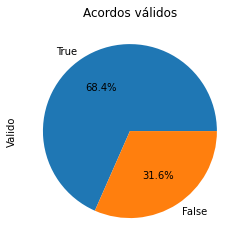

In [15]:
dados['Valido'].value_counts().plot.pie(title='Acordos válidos', autopct='%1.1f%%')

In [16]:
acordos_validos = dados[dados['Valido'] == True]
acordos_invalidos = dados[dados['Valido'] == False]

In [17]:
acordos_validos['doc tipo'].value_counts()

CNPJ    347
CPF     337
Name: doc tipo, dtype: int64

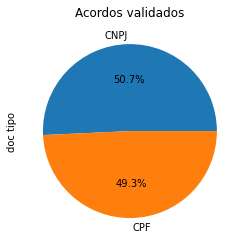

In [18]:
acordos_validos['doc tipo'].value_counts().plot.pie(title='Acordos validados', autopct='%1.1f%%')

Assim, dos acordos validados, **$337$ deles são referentes a pessoas físicas** (CPF, com comprimento de 11) e **$347$ são sobre pessoas jurídicas** (CNPJ, com comprimento de 14).

In [19]:
acordos_invalidos['doc tipo'].value_counts()

CNPJ    165
CPF     151
Name: doc tipo, dtype: int64

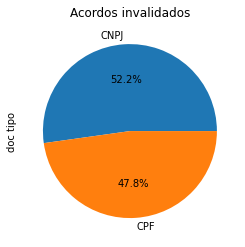

In [20]:
acordos_invalidos['doc tipo'].value_counts().plot.pie(title='Acordos invalidados', autopct='%1.1f%%')

Dos acordos invalidos, **$151$ são referentes a CPF** e **$165$ são de CNPJ**.

## Valor total em reais

Para os acordos validados, **o montante total gerado é de R$\$41.7$ milhões**, enquanto os **acordos invalidados geram um total de R$\$19.1$ milhões** (**total: R$\$60.8$ milhões**). Assim, os acordos invalidados representam uma receita de um total de $31.54\%$, ao passo que para os acordos validados este valor é de $68.54\%$.

In [21]:
print('Valor total gerado pelos acordos válidos: R$' + str(round(acordos_validos['ValorContrato'].sum()/1e6, 1)) + ' mi')
print('Porcentagem em relação à todos os acordos (válidos e inválidos): ' +
      str(round(100*acordos_validos['ValorContrato'].sum()/dados['ValorContrato'].sum(), 2)) +
      '%'
     )

Valor total gerado pelos acordos válidos: R$41.7 mi
Porcentagem em relação à todos os acordos (válidos e inválidos): 68.54%


In [22]:
print('Valor total gerado pelos acordos inválidos: R$' + str(round(acordos_invalidos['ValorContrato'].sum()/1e6, 1)) + ' mi')
print('Porcentagem em relação à todos os acordos (válidos e inválidos): ' +
      str(round(100*acordos_invalidos['ValorContrato'].sum()/dados['ValorContrato'].sum(), 2)) + 
      '%'
     )

Valor total gerado pelos acordos inválidos: R$19.1 mi
Porcentagem em relação à todos os acordos (válidos e inválidos): 31.46%


Dos cálculos apresentados abaixo, é possível concluir que,
- Para os acordos válidos, **R$\$19.8$ milhões derivam de contratos com pessoas físicas**, enquanto **R$\$21.9$ milhões são relacionados a pessoas jurídicas**
- Já para os acordos inválidos, os contratos com **CPF representam um montante de R$\$9.1$ milhões**, ao passo que, para o caso de **CNPJ, este valor é de R$\$10.0$**
- Tanto para os acordos válidos quanto para os inválidos, a porcentagem de receita gerado por CPF equivale à aproximadamente $48.0\%$. Para CNPJ, este valor é de $52.0\%$

In [23]:
print('Acordos válidos:')
print('Valor total gerado por CPF: R$' +
      str(round(acordos_validos[acordos_validos['doc tipo'] == 'CPF']['ValorContrato'].sum()/1e6,1)) + 
      ' mi (' +
      str(round(100*(acordos_validos[acordos_validos['doc tipo'] == 'CPF']['ValorContrato'].sum()/acordos_validos['ValorContrato'].sum()), 2)) +
      '%)'
     )
print('Valor total gerado por CNPJ: R$' +
      str(round(acordos_validos[acordos_validos['doc tipo'] == 'CNPJ']['ValorContrato'].sum()/1e6,1)) + 
      ' mi (' +
      str(round(100*(acordos_validos[acordos_validos['doc tipo'] == 'CNPJ']['ValorContrato'].sum()/acordos_validos['ValorContrato'].sum()), 2)) +
      '%)'
     )

Acordos válidos:
Valor total gerado por CPF: R$19.8 mi (47.57%)
Valor total gerado por CNPJ: R$21.9 mi (52.43%)


In [24]:
print('Acordos inválidos:')
print('Valor total gerado por CPF: R$' +
      str(round(acordos_invalidos[acordos_invalidos['doc tipo'] == 'CPF']['ValorContrato'].sum()/1e6,1)) + 
      ' mi (' +
      str(round(100*(acordos_invalidos[acordos_invalidos['doc tipo'] == 'CPF']['ValorContrato'].sum()/acordos_invalidos['ValorContrato'].sum()), 2)) +
      '%)'
     )
print('Valor total gerado por CNPJ: R$' +
      str(round(acordos_invalidos[acordos_invalidos['doc tipo'] == 'CNPJ']['ValorContrato'].sum()/1e6,1)) + 
      ' mi (' +
      str(round(100*(acordos_invalidos[acordos_invalidos['doc tipo'] == 'CNPJ']['ValorContrato'].sum()/acordos_invalidos['ValorContrato'].sum()), 2)) +
      '%)'
     )

Acordos inválidos:
Valor total gerado por CPF: R$9.1 mi (47.65%)
Valor total gerado por CNPJ: R$10.0 mi (52.35%)


Por fim, um resumo de toda a receita presente no arquivo csv, bem como as projeções desta receita sobre o tipo de documento e a validade do contrato são apresentadas na tabela abaixo. Cada valor na tabela representa milhões de reais.

|  | Total | CPF | CNPJ |
| - | - | - | - |
| **Total** | $60.8$ | $28.9$ | $31.9$ |
| **Válido** | $41.7$ | $19.8$ | $21.9$ |
| **Inválido** | $19.1$ | $9.1$ | $10.0$ |